In [1]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
SEED=42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [3]:
CSV_PATH="../../../data/processed/03_processed_data/only_frontal_labels_filtered.csv"
IMAGE_DIR="../../../data/processed/03_processed_data/only_frontal_images"
# 저장 경로
RESULT_DIR="../../../src/results"
os.makedirs(RESULT_DIR, exist_ok=True)
MODEL_DIR="../../../src/models"
os.makedirs(MODEL_DIR, exist_ok=True)
df=pd.read_csv(CSV_PATH)
df.head(2)

,filename,male,female,0s,10s,20s,30s,40s,50s,60+
0,F0001_IND_D_18_0_01.JPG,0,1,0,1,0,0,0,0,0
1,F0001_IND_D_18_0_02.JPG,0,1,0,1,0,0,0,0,0


In [4]:
train_df, test_df=train_test_split(df, test_size=0.1, random_state=SEED, shuffle=True)
train_df, val_df=train_test_split(train_df, test_size=0.1, random_state=SEED, shuffle=True)

print(train_df.shape, val_df.shape, test_df.shape)

(23588, 10) (2621, 10) (2913, 10)


# 전처리

In [5]:
BATCH_SIZE=16
IMAGE_SIZE=(224, 224)
LABEL_COLS=["male","female","0s","10s","20s","30s","40s","50s","60+"]

In [6]:
# Dataset 클래스
class AgeSexDataset(Dataset):
    def __init__(self, image_dir, dataframe, transform=None):
        self.image_dir=image_dir
        self.dataframe=dataframe.reset_index(drop=True)
        self.transform=transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path=os.path.join(self.image_dir, self.dataframe.loc[idx, "filename"])
        # L: 흑백 / RGBA: 투명(PNG) / RGB: 컬러 -> 자동 적용됨 but 흑백, 투명 오류 예방용으로 .convert()
        image=Image.open(img_path).convert("RGB")

        # PyTorch 텐서는 float32가 표준
        # 또한 다중 이진 분류(BCEWithLogitsLoss)는 float 타입 기대
        # astype(np.float32)로 변환 후 torch.tensor(label) 적용하는 게 정석
        label=self.dataframe.loc[idx, LABEL_COLS].values.astype(np.float32)

        if self.transform:
            image=self.transform(image)

        return image, torch.tensor(label)

# 이미지 전처리(ImageNet 사전학습 모델이기 때문에 Normalize 값도 맞춰야 함)
transform=transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset=AgeSexDataset(IMAGE_DIR, train_df, transform)
val_dataset=AgeSexDataset(IMAGE_DIR, val_df, transform)
test_dataset=AgeSexDataset(IMAGE_DIR, test_df, transform)

# DataLoader 클래스
train_loader=DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader=DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader=DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# VGG16

In [7]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
EPOCHS=20
LEARNING_RATE=0.0001

class VGG16MultiLabel(nn.Module):
    def __init__(self, num_classes):
        super(VGG16MultiLabel, self).__init__()
        self.base_model=models.vgg16(pretrained=True)
        in_features=self.base_model.classifier[6].in_features
        self.base_model.classifier[6]=nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

model=VGG16MultiLabel(num_classes=len(LABEL_COLS)).to(device)

# 손실함수 및 옵티마이저
loss_function=nn.BCEWithLogitsLoss()
optimizer=optim.Adam(model.parameters(), lr=LEARNING_RATE)

/home/julianjeong/miniconda3/envs/WSL_CUDA_PT01/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/julianjeong/miniconda3/envs/WSL_CUDA_PT01/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/julianjeong/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:09<00:00, 58.6MB/s] 


# PyTorch 학습 루프 + history 저장

In [9]:
# 학습 기록 리스트
train_loss_list=[]
val_loss_list=[]
train_acc_list=[]
val_acc_list=[]

# 최적 모델 저장 기준
# 초기값을 매우 크게 잡아서 첫 번째 val_loss가 무조건 더 작게 만들어 비교 가능
# 최적의 모델 성능을 계속 업데이트할 기준 값
best_val_loss=float("inf")

for epoch in range(EPOCHS):
    model.train()  # PyTorch 내부의 학습 메서드로, Dropout, BatchNormalization 등이 학습용 동작 하도록 설정
    train_loss=0  # 에폭(한 번 전체 데이터 학습) 시작 전 손실 값 초기화
    correct_train=0
    total_train=0
    
    for images, labels in train_loader:
        images, labels=images.to(device), labels.to(device)
        
        optimizer.zero_grad()  # 이전 단계의 gradient 초기화 -> PyTorch는 기본적으로 gradient가 누적됨 -> 매번 초기화 필요
        outputs=model(images)  # 순전파 호출 -> forward() 호출
        loss=loss_function(outputs, labels)  # output과 정답 labels 비교 -> 손실 계산
        loss.backward()  # PyTorch 내부 역전파 자동 실행 -> gradient 계산
        optimizer.step()  # 계산된 gradient를 바탕으로 파라미터 업데이트 -> 한 번의 학습이 실제로 적용되는 단계
        
        train_loss+=loss.item()  # loss는 tensor 형태 -> .item()으로 파이썬 숫자 추출 -> 모든 배치 손실 누적 합산
        
        # 정확도
        # 다중 이진 분류: 전체 라벨이 완벽 일치한 경우만 정답 처리
        preds=torch.sigmoid(outputs)>0.5
        correct_train+=(preds.cpu()==labels.cpu()).all(dim=1).sum().item()
        total_train+=labels.size(0)

    # 평균 손실 계산
    # len(train_loader): 배치 개수
    # epoch 단위로 손실 흐름 모니터링
    avg_train_loss=train_loss/len(train_loader)  
    train_accuracy=correct_train/total_train

    # 검증
    model.eval()  # PyTorch 내부 평가 메서드 -> Dropout 비활성화, BatchNormalization을 평균값, 분산값 고정 사용
    val_loss=0
    correct_val=0
    total_val=0

    with torch.no_grad():  # gradient 기록 비활성화 -> 메모리 사용 줄이고 속도 향상 -> 검증, 테스트, 추론단계에서 필수
        for images, labels in val_loader:
            images, labels=images.to(device), labels.to(device)
            outputs=model(images)
            loss=loss_function(outputs, labels)
            val_loss+=loss.item()  # 검증 손실 계산 로직과 동일 -> 누적
            
            preds=torch.sigmoid(outputs)>0.5
            correct_val+=(preds.cpu()==labels.cpu()).all(dim=1).sum().item()
            total_val+=labels.size(0)

    avg_val_loss=val_loss/len(val_loader)  # 평균 손실 계산
    val_accuracy=correct_val/total_val
    
    # 기록
    train_loss_list.append(avg_train_loss)
    val_loss_list.append(avg_val_loss)
    train_acc_list.append(train_accuracy)
    val_acc_list.append(val_accuracy)

    # 진행 사항 출력용
    print(f"Epoch [{epoch+1}/{EPOCHS}] Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # 현재 모델 파라미터(가중치, 편향 등) 저장
    # state_dict(): 파라미터(가중치, 편향 등) 딕셔너리로 변환
    # 최적 성능일 때만 저장 -> EarlyStopping 같이
    if avg_val_loss<best_val_loss:
        best_val_loss=avg_val_loss
        torch.save(model.state_dict(), "../../../src/models/08_vgg16_best.pth")  # PyTorch 모델 파라미터 파일

Epoch [1/20] Train Loss: 0.1582, Val Loss: 0.0848
Epoch [2/20] Train Loss: 0.0655, Val Loss: 0.0896
Epoch [3/20] Train Loss: 0.0372, Val Loss: 0.0364
Epoch [4/20] Train Loss: 0.0249, Val Loss: 0.0360
Epoch [5/20] Train Loss: 0.0184, Val Loss: 0.0553
Epoch [6/20] Train Loss: 0.0162, Val Loss: 0.0264
Epoch [7/20] Train Loss: 0.0157, Val Loss: 0.0355
Epoch [8/20] Train Loss: 0.0131, Val Loss: 0.0285
Epoch [9/20] Train Loss: 0.0122, Val Loss: 0.0374
Epoch [10/20] Train Loss: 0.0119, Val Loss: 0.0302
Epoch [11/20] Train Loss: 0.0108, Val Loss: 0.0243
Epoch [12/20] Train Loss: 0.0108, Val Loss: 0.0277
Epoch [13/20] Train Loss: 0.0083, Val Loss: 0.0222
Epoch [14/20] Train Loss: 0.0110, Val Loss: 0.0283
Epoch [15/20] Train Loss: 0.0097, Val Loss: 0.0181
Epoch [16/20] Train Loss: 0.0081, Val Loss: 0.0500
Epoch [17/20] Train Loss: 0.0096, Val Loss: 0.0355
Epoch [18/20] Train Loss: 0.0083, Val Loss: 0.0209
Epoch [19/20] Train Loss: 0.0072, Val Loss: 0.0273
Epoch [20/20] Train Loss: 0.0075, Val Lo

# Loss & Accuracy 그래프

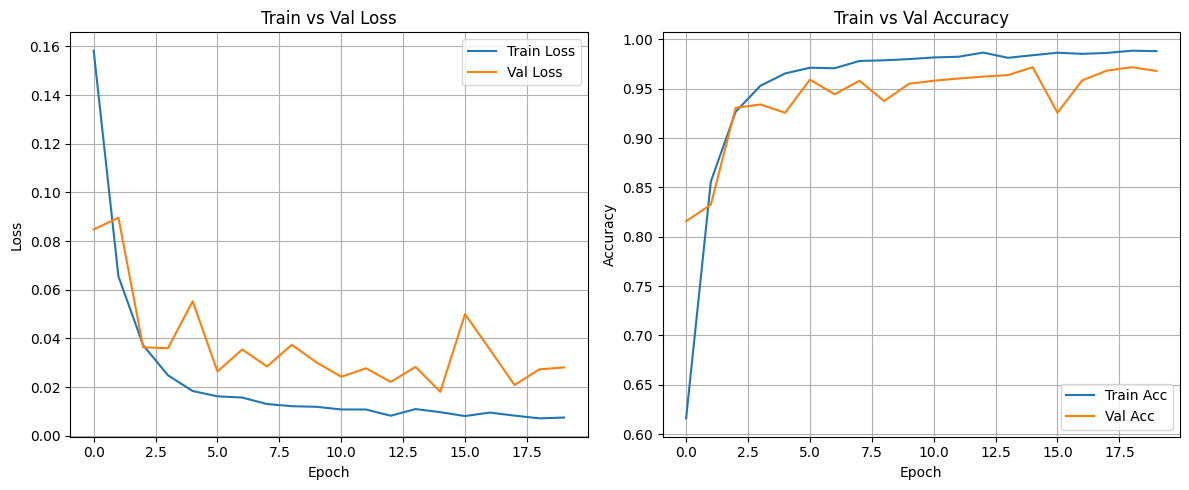

In [10]:
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list, label="Val Loss")
plt.title("Train vs Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label="Train Acc")
plt.plot(val_acc_list, label="Val Acc")
plt.title("Train vs Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(RESULT_DIR, "08_acc_loss_graph.jpg"))
plt.show()

# Classification Report

In [11]:
# 모델 로드
model.load_state_dict(torch.load("../../../src/models/08_vgg16_best.pth"))
model.eval()

# 전체 데이터 수집
all_images=[]
all_labels=[]
all_preds=[]

with torch.no_grad():
    for images, labels in test_loader:
        images=images.to(device)
        outputs=model(images)
        preds=torch.sigmoid(outputs).cpu().numpy()

        all_images.extend(images.cpu())
        all_labels.extend(labels.numpy())

        # 성별 정리
        sex_preds=preds[:, :2]
        sex_argmax=np.argmax(sex_preds, axis=1)
        sex_result=np.zeros_like(sex_preds)
        sex_result[np.arange(len(sex_preds)), sex_argmax]=1

        # 연령대 정리
        age_preds=preds[:, 2:]
        age_argmax=np.argmax(age_preds, axis=1)
        age_result=np.zeros_like(age_preds)
        age_result[np.arange(len(age_preds)), age_argmax]=1

        clean_preds=np.concatenate([sex_result, age_result], axis=1)
        all_preds.extend(clean_preds)

all_labels=np.array(all_labels)
all_preds=np.array(all_preds)

# Classification Report
report=classification_report(all_labels, all_preds, target_names=LABEL_COLS, digits=4)
print(report)
with open(os.path.join(RESULT_DIR, "08_classification_report_clean.txt"), "w") as f:
    f.write(report)

              precision    recall  f1-score   support

        male     0.9992    0.9882    0.9937      1276
      female     0.9909    0.9994    0.9951      1637
          0s     0.9750    0.9512    0.9630        41
         10s     0.9856    0.9955    0.9905      1102
         20s     0.9860    0.9564    0.9710       367
         30s     0.9154    0.9520    0.9333       125
         40s     0.9750    0.9750    0.9750       559
         50s     0.9367    0.9599    0.9482       324
         60+     0.9948    0.9646    0.9794       395

   micro avg     0.9852    0.9852    0.9852      5826
   macro avg     0.9732    0.9713    0.9721      5826
weighted avg     0.9854    0.9852    0.9853      5826
 samples avg     0.9852    0.9852    0.9852      5826



# 혼동행렬 히트맵

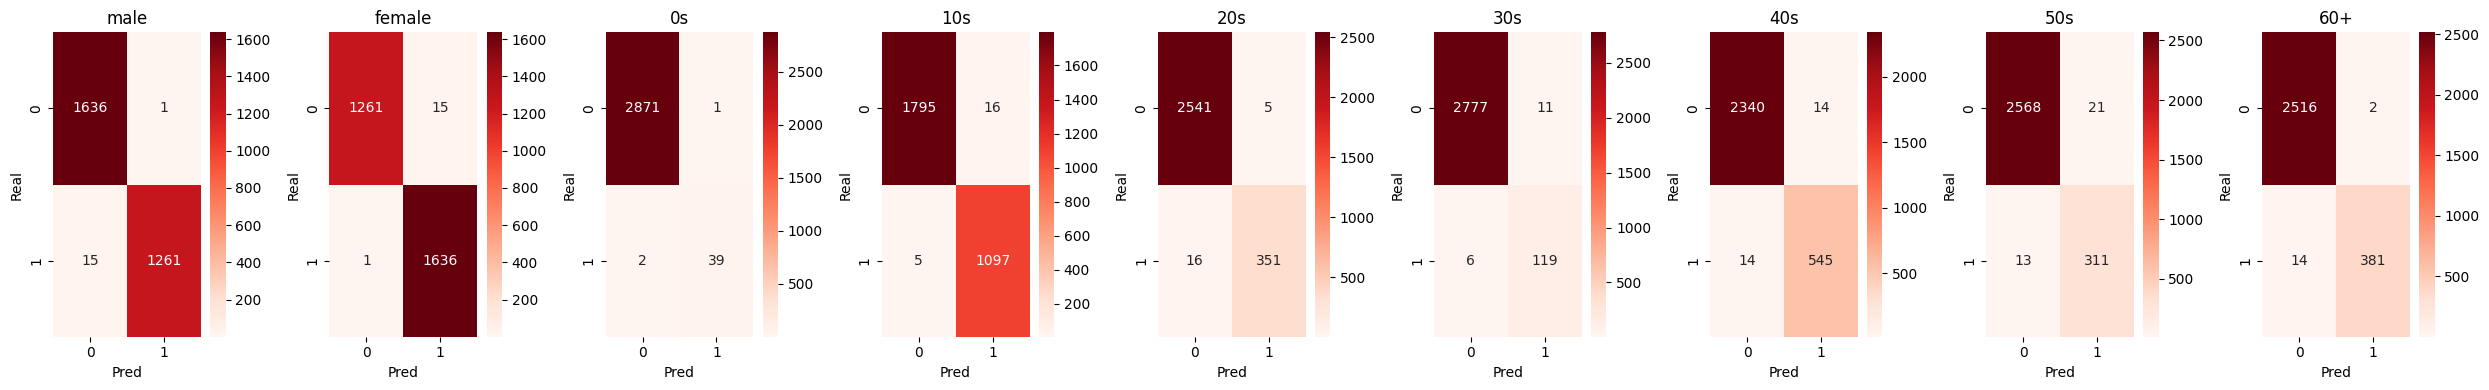

In [12]:
fig, axes=plt.subplots(1, len(LABEL_COLS), figsize=(25, 4))

for i, label_name in enumerate(LABEL_COLS):
    cm=confusion_matrix(all_labels[:, i], all_preds[:, i])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", ax=axes[i])
    axes[i].set_title(label_name)
    axes[i].set_xlabel("Pred")
    axes[i].set_ylabel("Real")

plt.tight_layout()
plt.savefig(os.path.join(RESULT_DIR, "08_confusion_matrix_clean.jpg"))
plt.show()

# 샘플 이미지

In [ ]:
# 역정규화 함수
def unnormalize(img_tensor):
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    img=img_tensor.clone().cpu().numpy().transpose((1, 2, 0))
    img=std * img + mean
    img=np.clip(img, 0, 1)
    return img

# 샘플 이미지 시각화
random.seed(SEED)  # 재현성 고정
indices=random.sample(range(len(all_images)), 10)

plt.figure(figsize=(20, 8))
for i, idx in enumerate(indices):
    img_tensor=all_images[idx]
    img=unnormalize(img_tensor)  # 역정규화 적용

    real_label=all_labels[idx].astype(int)
    pred_label=all_preds[idx].astype(int)

    real_text=[LABEL_COLS[j] for j, v in enumerate(real_label) if v==1]
    pred_text=[LABEL_COLS[j] for j, v in enumerate(pred_label) if v==1]

    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"Real: {real_text}\nPred: {pred_text}")
    plt.axis("off")


plt.tight_layout()
plt.savefig(os.path.join(RESULT_DIR, "08_sample_predictions_clean.jpg"))
plt.show()

# VGG16 기반
- 지난 07번 resnet50과 비교했을때, 모든 지표에서 약간 더 우세하고, val_loss, macro avg, weighted avg 모두 우세함  
- 성능 차이는 경미한 수준이고, ResNet50이 더 깊은 구조이므로 이후 fine-tuning 여지가 있음
- 현재 결과 기준으로는 VGG16이 더 우수한 baseline임

### 다음은 EfficientNetB0 예정